## Model Factory

In [2]:
#libraries for modeling
from multiprocessing.pool import ThreadPool
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession, Window, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F
import itertools
from itertools import repeat
import pickle
import pyspark
import copy

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

#libraries for plotting
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import MulticlassMetrics

class CreateBestModel:
    def __init__(self, algo, avgprecision, avgrecall, avgfscore, hyperparams, ootmodel, ootprecision, ootrecall, ootfscore):
        self.algo = algo
        self.gsPrecision = avgprecision
        self.gsFScore = avgfscore
        self.gsRecall = avgrecall
        self.hyperParams = hyperparams
        self.model = ootmodel
        self.ootPrecision = ootprecision
        self.ootFScore = ootfscore
        self.ootRecall = ootrecall

#function-based
def sample(df, sampling_method, ratio):

    notfraud = df.select('*').where(df.Class == 0.0)
    fraud = df.select('*').where(df.Class == 1.0)

    if sampling_method == "over":
        nrows = notfraud.select("Class").count()
        sample_size = int(nrows*ratio/(1-ratio))
        sampled = fraud.rdd.takeSample(True, sample_size, 46)
        fraud = sqlContext.createDataFrame(sampled)

    elif sampling_method == "under":
        nrows = fraud.select("Class").count()
        sample_size = int(nrows*(1-ratio)/ratio)
        sampled = notfraud.rdd.takeSample(False, sample_size, 46)
        notfraud = sqlContext.createDataFrame(sampled)
    else:
        return df
    
    sampled = fraud.union(notfraud)

    #shuffle undersampled dataframe
    nrows = sampled.select("Class").count()
    shuffled = sampled.rdd.takeSample(False, nrows, 46)
    shuffled_df = sqlContext.createDataFrame(shuffled)

    return shuffled_df

def generateParamGrid(*args):
    
    grid = list(itertools.product(*args))
    return grid

def generateClassifier(algo, params, features):

    ############################################################################
    #TODO: complete this section

    def lr(params,features):
        print(params)
        if len(params) > 2:
            lrClassifier = LogisticRegression(featuresCol = 'features',
                                          labelCol = 'Class',
                                          threshold=params[0],
                                           maxIter=params[1],
                                           weightCol=params[2])
                                          #regParam=params[2])
                                          #elasticNetParam=params[2])
        else:
            lrClassifier = LogisticRegression(featuresCol = 'features',
                                          labelCol = 'Class',
                                          threshold=params[0],
                                           maxIter=params[1])
        return lrClassifier


    def gbm(params,features):
        gbmClassifier = GBTClassifier(featuresCol = 'features',
                                      labelCol = 'Class',
                                      maxDepth = params[0],
                                      minInfoGain = params[1])
        return gbmClassifier

    def rf(params,features):
        rfClassifier = RandomForestClassifier(featuresCol='features',
                                              labelCol='Class',
                                              maxDepth=params[0],
                                              minInfoGain=params[1],
                                              numTrees=params[2])

        return rfClassifier

    def mlp(params,features):
        input_layers = len(features)
        layers = [input_layers, params[1], 2]
        print(layers)
        mlpClassifier = MultilayerPerceptronClassifier(featuresCol = 'features',
                                                       labelCol = 'Class',
                                                       maxIter = params[0],
                                                       layers = layers,
                                                       stepSize = params[2])
        return mlpClassifier

    def svm(params, features):
        svmClassifier = LinearSVC(featuresCol = 'features',
                         labelCol='Class', 
                         maxIter=params[0],
                         regParam=params[1],
                         tol =params[2]
                         )
        
        return svmClassifier

    def xg(params,features):
        return
    ############################################################################

    getClassifier = {
        'lr':lr,
        'gbm':gbm,
        'rf':rf,
        'mlp':mlp,
        'svm':svm,
        'xg':xg}

    return getClassifier[algo](params,features)

def crossValidate(df, folds, k, classifier, features, sampling_method, ratio, pool):

    def build(fold, df, classifier, features, sampling_method, ratio):

        validation = fold
        train = df.subtract(fold)

#         #add class weight
#         notfraud_count = train.select("Class").where(train.Class == 0.0).count()
#         total_count = train.select("Class").count()
#         balance_ratio = notfraud_count / total_count
#         train=train.withColumn("classWeights", F.when(train.Class == 1.0,balance_ratio).otherwise(1-balance_ratio))
        
        train = sample(train, sampling_method, ratio)
        fraud_count = train.select("Class").where(train.Class == 1.0).count()
        tot_count = train.select("Class").count()
        fraud_ratio = fraud_count / tot_count
        print("train: " + str(tot_count))
        print("fraud ratio: " + str(fraud_ratio))
        
        vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
        vector_train = vectorAssembler.transform(train)
        vector_validate = vectorAssembler.transform(validation)
        model = classifier.fit(vector_train)
        pred = model.transform(vector_validate)
        pos = pred.filter(pred.prediction == 1.0).count()
        if pos != 0:
            precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pos
        else:
            precision = 0
        fraud = pred.filter(pred.Class == 1.0).count()
        if fraud != 0:
            recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / fraud
        else:
            recall = 0
        precision_recall = precision + recall
        if precision_recall != 0:
            f_score = 2 * precision * recall /(precision_recall)
        else:
            f_score = 0
        #print("\n precision, recall, f_score: " + str(precision) + ", " + str(recall) + ", " + str(f_score))
        return [precision, recall, f_score]

    #call multiprocessing here
    cvperformance = pool.map(lambda fold: build(fold, df, classifier, features, sampling_method, ratio), folds)

    #calculate metrics
    precision_sum = sum([x[0] for x in cvperformance])
    recall_sum = sum([x[1] for x in cvperformance])

    avg_precision = precision_sum/k
    avg_recall = recall_sum/k
    if avg_precision+avg_recall == 0:
        avg_fscore = 0
    else:
        avg_fscore = 2 * avg_precision * avg_recall /(avg_precision+avg_recall)
    return [avg_precision,avg_recall,avg_fscore]

def gridSearch(df, folds, k, algo, grid, features, sampling_method, ratio, pool):

    best_hyper = None
    best_precision = 0
    best_recall = 0
    best_fscore = 0

    for i in range(len(grid)):
        params = list(grid[i])
        print(params)
        classifier = generateClassifier(algo, params, features)
        modelPerformance = crossValidate(df, folds, k, classifier, features, sampling_method, ratio, pool)
        print(modelPerformance)
        if modelPerformance[2] > best_fscore:
            best_hyper = params
            best_precision = modelPerformance[0]
            best_recall = modelPerformance[1]
            best_fscore = modelPerformance[2]

    return best_hyper, best_precision, best_recall, best_fscore

def TrainTest(traindf,testdf,algo,features,params):
    vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
    classifier = generateClassifier(algo, params, features)
    vector_train = vectorAssembler.transform(traindf)
    vector_test = vectorAssembler.transform(testdf)
    m = classifier.fit(vector_train)
    pred = m.transform(vector_test)
    pos = pred.filter(pred.prediction == 1.0).count()
    if pos != 0:
        precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pos
    else:
        precision = 0
    fraud = pred.filter(pred.Class == 1.0).count()
    if fraud != 0:
        recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / fraud
    else:
        recall = 0
    precision_recall = precision + recall
    if precision_recall != 0:
        f_score = 2 * precision * recall /(precision_recall)
    else:
        f_score = 0
    print("\n precision, recall, f_score: " + str(precision) + ", " + str(recall) + ", " + str(f_score))
    predictionAndLabels = pred.select('Class','prediction').rdd.map(lambda lp: (float(lp.prediction), lp.Class))
    metrics = MulticlassMetrics(predictionAndLabels)
    print(metrics.confusionMatrix().toArray())
    #evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderPR")
    #print("Area under Precision Recall Curve = %s" % evaluator.evaluate(pred))
    
    return m, precision, recall, f_score

def tune(df, k, stratification_flag, sampling_method, ratio, modelobj_flag, features, algo, *args, **kwargs):

    """
    Entry point of this suite of functions. returns cv metrics or a model object
    Example:
        >>> cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True,
        'None', 0, False, features, 'mlp', [100], [15], [0.03])
    :param df: data for modeling purpose
    :type df: : pyspark dataframe
    :param k: number of folds for cross validation
    :type k: int
    :param stratification_flag: specifies whether fraud ratio is fixed for each fold. True for stratification
    :type stratification_flag: boolean
    :param sampling_method: "over" for oversampling minority class, "under" for undersampling majority class, "None"
    :type sampling_method: str
    :param ratio: targeted fraud ratio after sampling.
    :type ratio: float
    :param modelobj_flag: specifies whether to return a model object for out of time test. if False, returns cv performancce
    :type modelobj_flag: float
    :param features: features for training
    :type features: list
    :param *args: a sequence of params for hyperparams tuning. ex. [values for params1], [values for params2],...
    :type *args: list
    :returns: model object or cross validation metrics depending on modelobj_flag
    """


    pool = ThreadPool(3)

    #reduce df dimenions to include features and class
    cols = features+['Class', 'index']
    df = df.select(cols)
    df = df.select(*(F.col(c).cast("double").alias(c) for c in df.columns))
    df.cache()
    #df.drop("index")
    
    ########################ClassWeights#################################
    if algo in ["lr", "svm"] and ["ClassWeigts"] in args:
        #add class weight
        balance_ratio = args[-1][0]
        df=df.withColumn("classWeights", when(df.Class == 1.0,balance_ratio).otherwise(1-balance_ratio))
    ########################ClassWeights#################################
    
    folds = []
    
    if stratification_flag == False:
        tot_count = df.select("Class").count()
        n = int(tot_count / k)

        #create sub-dataframe iteratively
        fold_start = 1
        fold_end = n
        for i in range(k):
            fold = df.select('*').where(df.index.between(fold_start, fold_end))
            folds.append(fold)
            fold_start = fold_end + 1
            fold_end = fold_start + n
            if i == k-2:
                end = tot_count
                
    if stratification_flag == True:
        fraud = df.select("*").where(df.Class == 1.0)
        #shuffle undersampled dataframe
        nrows = fraud.select("Class").count()
        shuffled = fraud.rdd.takeSample(False, nrows, 46)
        fraud = sqlContext.createDataFrame(shuffled)
        #add row index to dataframe
        fraud = fraud.withColumn('dummy', F.lit('7'))
        fraud = fraud.withColumn("temp_index", F.row_number().over(Window.partitionBy("dummy").orderBy("dummy")))
        fraud = fraud.drop('dummy')
        fraud_count = fraud.select("Class").count()
        each_fraud = int(fraud_count/k)

        notfraud = df.select("*").where(df.Class == 0.0)
        nrows = notfraud.select("Class").count()
        shuffled = notfraud.rdd.takeSample(False, nrows, 46)
        notfraud = sqlContext.createDataFrame(shuffled)
        #add row index to dataframe
        notfraud = notfraud.withColumn('dummy', F.lit('7'))
        notfraud = notfraud.withColumn("temp_index", F.row_number().over(Window.partitionBy("dummy").orderBy("dummy")))
        notfraud = notfraud.drop('dummy')
        notfraud_count = notfraud.select("Class").count()
        each_notfraud = int(notfraud_count/k)

        fraud_start = 1
        fraud_end = each_fraud
        notfraud_start = 1
        notfraud_end = each_notfraud

        for i in range(k):
            fraud_fold  = fraud.select('*').where(fraud.temp_index.between(fraud_start, fraud_end))
            notfraud_fold = notfraud.select('*').where(notfraud.temp_index.between(notfraud_start, notfraud_end))
            fold = fraud_fold.union(notfraud_fold).drop("temp_index")
            folds.append(fold)
            fraud_start = fraud_end + 1
            fraud_end = fraud_start + each_fraud
            notfraud_start = notfraud_end + 1
            notfraud_end = notfraud_start + each_notfraud
            if i == k-2:
                fraud_end = fraud_count
                notfraud_end = notfraud_count


    #generate hyperparam combo
    grid = generateParamGrid(*args)

    #conduct grid search:
    best_hyper, best_precision, best_recall, best_fscore = gridSearch(df, folds, k, algo, grid, features, sampling_method, ratio, pool)

    if modelobj_flag == True:
        #generate a model obj
        traindf = sample(df, sampling_method, ratio)
        testdf = sqlContext.read.csv("oot.csv", header = True)
        cols = features+['Class', 'index']
        testdf = testdf.select(cols)
        testdf = testdf.select(*(F.col(c).cast("double").alias(c) for c in testdf.columns))
        model, precision, recall, fscore = ootTest(traindf, testdf, algo,features,best_hyper)
        
        modelobj = CreateBestModel(algo, best_precision, best_recall, best_fscore, best_hyper, 
                                   model, precision, recall, fscore)
        return modelobj

    return best_hyper, best_precision, best_recall, best_fscore

def save(content, filename):

    pickle.dump(content, open(filename, "wb"))

def load(filename):

    content = pickle.load(open(filename, "rb"))
    return content

def generateStratifiedFolds(df,k):

    return folds

In [4]:
sc=pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

## STEP 1: Train base_train and test base_test with default params.

In [5]:
# import pyspark
# from pyspark.sql.types import DateType
# from pyspark.sql import SQLContext, SparkSession, Window
# import pyspark.sql.functions as F
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.linalg import Vectors
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.sql.functions import abs, sqrt
# import pyspark.sql.functions as func
# #from pyspark.mllib.tree import RandomForest, RandomForestModel
# #from pyspark.mllib.util import MLUtils
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# sc=pyspark.SparkContext.getOrCreate()
# sqlContext = SQLContext(sc)
trainingData = sqlContext.read.csv("base_train.csv", header = True)
sc1=pyspark.SparkContext.getOrCreate()
sqlContext1 = SQLContext(sc1)
testData = sqlContext1.read.csv("base_test.csv", header = True)
trainingData = trainingData.select(*(F.col(c).cast("double").alias(c) for c in trainingData.columns))
testData = testData.select(*(F.col(c).cast("double").alias(c) for c in testData.columns))
vectorAssembler = VectorAssembler(inputCols = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], outputCol = 'features')
df_train = vectorAssembler.transform(trainingData)
df_test = vectorAssembler.transform(testData)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Class')
rfModel = rf.fit(df_train)
pred = rfModel.transform(df_test)
pred = pred.select("features", "Class", "rawPrediction", "prediction")
pred.show()
pred.groupby('Class').agg({'Class': 'count'}).show()
pred.groupby('prediction').agg({'prediction': 'count'}).show()
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)
evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderROC")
print("Test Area Under ROC: ", evaluator.evaluate(pred))

+--------------------+-----+--------------------+----------+
|            features|Class|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[0.004722604,0.97...|  0.0|[19.9946040611091...|       0.0|
|[0.002797544,0.94...|  0.0|[19.9946040611091...|       0.0|
|[0.002574717,0.97...|  0.0|[19.9946040611091...|       0.0|
|[0.007631052,0.93...|  0.0|[19.9929002437546...|       0.0|
|[0.010660071,0.98...|  0.0|[19.9946040611091...|       0.0|
|[0.018060156,0.93...|  0.0|[19.9856889064570...|       0.0|
|[9.11E-5,0.993164...|  0.0|[19.9946040611091...|       0.0|
|[5.09E-5,0.956463...|  0.0|[19.9911261080119...|       0.0|
|[0.001525702,0.94...|  0.0|[19.9944845217981...|       0.0|
|[0.002950673,0.99...|  0.0|[19.9946040611091...|       0.0|
|[0.012572412,0.98...|  0.0|[19.9946040611091...|       0.0|
|[0.001882326,0.94...|  0.0|[19.9947020343690...|       0.0|
|[5.09E-5,0.943140...|  0.0|[19.9946040611091...|       0.0|
|[0.004441781,0.97...|  

## STEP 2   compare random cv vs stratified cv

In [7]:
sqlContext.clearCache()

df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
hiddenlayer = int((len(features) + 2) / 2)
cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, False, 'None', 0, False, features, 'rf', [5], [0], [20])
print("avg precision:", cv_precision)
print("avg recall:", cv_recall)
print("avg f-score:", cv_fscore)

[5, 0, 20]
train: 152482
fraud ratio: 0.0016592122348867407
train: 152538
fraud ratio: 0.0017372720240202441
train: 152562
fraud ratio: 0.0014420366801693738
train: 152553
fraud ratio: 0.0018223174896593315
train: 152499
fraud ratio: 0.0016655846923586384
[0.8711749716005036, 0.7126736355806124, 0.7839934087417116]
avg precision: 0.8711749716005036
avg recall: 0.7126736355806124
avg f-score: 0.7839934087417116


In [7]:
# stratified
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'None', 0, False, features, 'rf', [5], [0], [20])
print("grid search precision:", cv_precision)
print("grid search recall:", cv_recall)
print("grid search f-score:", cv_fscore)
print("grid search hyper:", cv_hyper)


[5, 0, 20]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.8537173576431558, 0.7436805922792173, 0.7949090334089431]
grid search precision: 0.8537173576431558
grid search recall: 0.7436805922792173
grid search f-score: 0.7949090334089431
grid search hyper: [5, 0, 20]


## conclusion: stratified is better and variance in stratified is small

## STEP 3 GRID SEARCH

In [8]:
#Use ClassWeight for logistric regression
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'rf', [4, 5, 6], [0], [100, 150, 200])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)


sqlContext.clearCache()

[4, 0, 100]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.8638682082564904, 0.6982548915917504, 0.7722825456768365]
[4, 0, 150]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.8653719676549866, 0.711158117398202, 0.7807225567102772]
[4, 0, 200]
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.8636782492387376, 0.6983077736647277, 0.7722389657078597]
[5, 0, 100]
train: 145268
fraud ratio: 0.001700305

## conclusion: best hyperparams are [6, 0, 100].

##  STEP4 FEATURE SELECTION

train before sampling: 181584
fraud ratio: 0.0016961846858754076
test: 45396
Precision is  0.8902439024390244
Recall is  0.8021978021978022
F1 score is  0.8439306358381503
Area under Precision Recall Curve = 0.8729666338346731
[[4.5296e+04 9.0000e+00]
 [1.8000e+01 7.3000e+01]]
(29,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28],[0.009867401545201923,0.005338619207018819,0.014067584427549233,0.04424261666710388,0.05864724799553147,0.018563845851873158,0.00667604673991056,0.0950267908123432,0.007330665944102226,0.0659203609111006,0.08533000648155876,0.03907037063181175,0.12262089784475727,0.0048027525628128835,0.06683721020248032,0.005071227380361747,0.1134369740398188,0.10147668544431061,0.04140360372540403,0.005456033286675302,0.007851156524588008,0.021302672247741187,0.008887676319430158,0.0023555094186932814,0.007501056704429167,0.004381669952297106,0.02147775902509658,0.008959415366051028,0.006096142739947034])


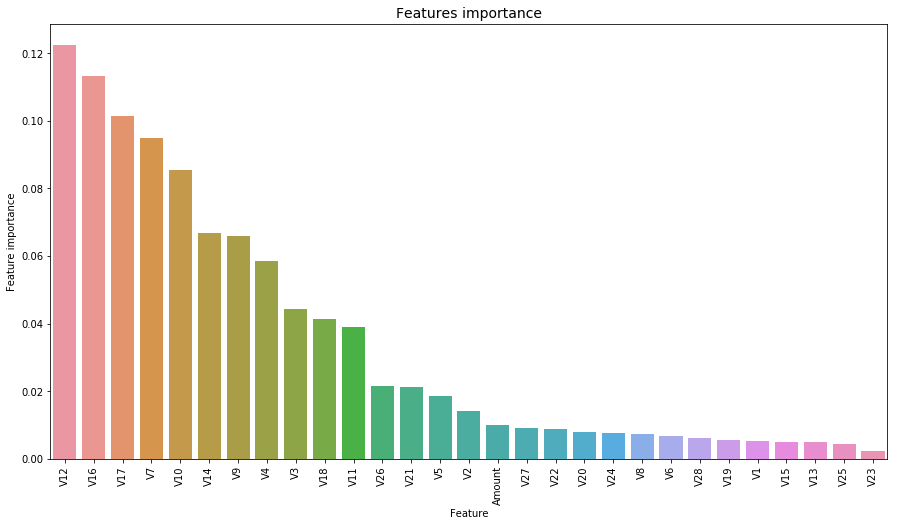

In [9]:
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import MulticlassMetrics
trainData = sqlContext.read.csv("base_train.csv", header = True)
testData = sqlContext.read.csv("base_test.csv", header = True)
trainData = trainData.select(*(F.col(c).cast("double").alias(c) for c in trainData.columns))
testData = testData.select(*(F.col(c).cast("double").alias(c) for c in testData.columns))
train_count = trainData.select("Class").count()
train_fraud_count = trainData.select("Class").where(trainData.Class == 1).count()
test_count = testData.select("Class").count()
print("train before sampling: " + str(train_count))
print("fraud ratio: " + str(train_fraud_count/train_count))
print("test: " + str(test_count))
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
df_train = vectorAssembler.transform(trainData)
df_test = vectorAssembler.transform(testData)

rfClassifier = RandomForestClassifier(featuresCol = 'features', labelCol = 'Class', maxDepth=6, minInfoGain=0.0, numTrees= 200)
rfModel = rfClassifier.fit(df_train)
pred = rfModel.transform(df_test)
pred = pred.select("features", "Class", "rawPrediction", "prediction")
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderPR")
print("Area under Precision Recall Curve = %s" % evaluator.evaluate(pred))
predictionAndLabels = pred.select('Class','prediction').rdd.map(lambda lp: (float(lp.prediction), lp.Class))
metrics = MulticlassMetrics(predictionAndLabels)
print(metrics.confusionMatrix().toArray())

featureImportance = rfModel.featureImportances
print(featureImportance)
tmp = pd.DataFrame({'Feature': features, 'Feature importance': featureImportance})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()


## STEP 5   Based on features important, stratified cv with top features and best hyperparams & features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4', 'V3', 'V18', 'V11']

In [10]:
features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4', 'V3', 'V18', 'V11']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'rf', [6], [0], [100])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[6, 0, 100]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.8538245088245089, 0.759862506610259, 0.804107891152442]
grid search precision: 0.8538245088245089
grid search recall: 0.759862506610259
grid search f-score: 0.804107891152442
grid search hyper: [6, 0, 100]


##  features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4', 'V3', 'V18', 'V11', 'V26', 'V21', 'V5', 'V2']

In [11]:
features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4', 'V3', 'V18', 'V11', 'V26', 'V21', 'V5', 'V2']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'rf', [6], [0], [100])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[6, 0, 100]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.8572899030793767, 0.763088313061872, 0.807450877121384]
grid search precision: 0.8572899030793767
grid search recall: 0.763088313061872
grid search f-score: 0.807450877121384
grid search hyper: [6, 0, 100]


## features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4', 'V3', 'V18', 'V11', 'V26', 'V21', 'V5', 'V2', 'Amount', 'V27', 'V22', 'V20']

In [13]:
features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4', 'V3', 'V18', 'V11', 'V26', 'V21', 'V5', 'V2', 'Amount', 'V27', 'V22', 'V20']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'rf', [6], [0], [100])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[6, 0, 100]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.9064276484655485, 0.759862506610259, 0.8266992191315437]
grid search precision: 0.9064276484655485
grid search recall: 0.759862506610259
grid search f-score: 0.8266992191315437
grid search hyper: [6, 0, 100]


## features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4', 'V3', 'V18', 'V11', 'V26', 'V21', 'V5', 'V2', 'Amount', 'V27', 'V22', 'V20', 'V24', 'V8', 'V6', 'V28']

In [14]:
features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4', 'V3', 'V18', 'V11', 'V26', 'V21', 'V5', 'V2', 'Amount', 'V27', 'V22', 'V20', 'V24', 'V8', 'V6', 'V28']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'rf', [6], [0], [100])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)


sqlContext.clearCache()

[6, 0, 100]
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.9234993447568183, 0.7598096245372818, 0.8336956592043311]
grid search precision: 0.9234993447568183
grid search recall: 0.7598096245372818
grid search f-score: 0.8336956592043311
grid search hyper: [6, 0, 100]


## features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4']

In [15]:
features = ['V12', 'V16', 'V17', 'V7', 'V10', 'V14', 'V9', 'V4']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'rf', [6], [0], [100])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)


sqlContext.clearCache()

[6, 0, 100]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.8614779372674111, 0.7695399259650978, 0.8129177282601269]
grid search precision: 0.8614779372674111
grid search recall: 0.7695399259650978
grid search f-score: 0.8129177282601269
grid search hyper: [6, 0, 100]


## features = ['V12', 'V16', 'V17', 'V7', 'V10']

In [16]:
features = ['V12', 'V16', 'V17', 'V7', 'V10']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'rf', [6], [0], [100])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)


sqlContext.clearCache()

[6, 0, 100]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.8281137602033125, 0.733897408778424, 0.7781641448609568]
grid search precision: 0.8281137602033125
grid search recall: 0.733897408778424
grid search f-score: 0.7781641448609568
grid search hyper: [6, 0, 100]


## Based on T test, remove V13, V22, V23, V25, V26

In [17]:
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V14','V15','V16','V17','V18','V19','V20','V21','V24','V27','V28','Amount']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'rf', [6], [0], [100])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[6, 0, 100]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.8556228282057802, 0.759862506610259, 0.8049044989039639]
grid search precision: 0.8556228282057802
grid search recall: 0.759862506610259
grid search f-score: 0.8049044989039639
grid search hyper: [6, 0, 100]


## Conclusion: All features are the best

## STEP6 undersampling with all features.

In [8]:
#undersampling
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
for i in [0.003, 0.005]:
        gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'under', i, False, features, 'rf', [6], [0], [100])
        print("grid search precision:", gs_precision)
        print("grid search recall:", gs_recall)
        print("grid search f-score:", gs_fscore)
        print("grid search hyper:", gs_hyper)


        sqlContext.clearCache()

[6, 0, 100]
train: 82333
fraud ratio: 0.003000012145798161
train: 82000
fraud ratio: 0.003
train: 82000
fraud ratio: 0.003
train: 82000
fraud ratio: 0.003
train: 82333
fraud ratio: 0.003000012145798161
[0.8566827697262479, 0.763088313061872, 0.8071814795635384]
grid search precision: 0.8566827697262479
grid search recall: 0.763088313061872
grid search f-score: 0.8071814795635384
grid search hyper: [6, 0, 100]
[6, 0, 100]
train: 49200
fraud ratio: 0.005
train: 49399
fraud ratio: 0.0050001012166238186
train: 49200
fraud ratio: 0.005
train: 49200
fraud ratio: 0.005
train: 49399
fraud ratio: 0.0050001012166238186
[0.8407556899182979, 0.7695399259650978, 0.8035730396241875]
grid search precision: 0.8407556899182979
grid search recall: 0.7695399259650978
grid search f-score: 0.8035730396241875
grid search hyper: [6, 0, 100]


## Oversampling

In [12]:
#oversampling
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
for i in [0.003, 0.005]:
        gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'over', i, False, features, 'rf', [6], [0], [100])
        print("grid search precision:", gs_precision)
        print("grid search recall:", gs_recall)
        print("grid search f-score:", gs_fscore)
        print("grid search hyper:", gs_hyper)


        sqlContext.clearCache()

[6, 0, 100]
train: 145456
fraud ratio: 0.002997470025299747
train: 145456
fraud ratio: 0.002997470025299747
train: 145457
fraud ratio: 0.0029974494180410706
train: 145456
fraud ratio: 0.002997470025299747
train: 145459
fraud ratio: 0.002997408204373741
[0.8559770955165693, 0.7565838180856689, 0.8032173093828963]
grid search precision: 0.8559770955165693
grid search recall: 0.7565838180856689
grid search f-score: 0.8032173093828963
grid search hyper: [6, 0, 100]
[6, 0, 100]
train: 145748
fraud ratio: 0.004994922743365261
train: 145748
fraud ratio: 0.004994922743365261
train: 145749
fraud ratio: 0.004994888472648183
train: 145748
fraud ratio: 0.004994922743365261
train: 145751
fraud ratio: 0.004994819932624819
[0.8502824262317056, 0.7629825489159175, 0.8042704240886565]
grid search precision: 0.8502824262317056
grid search recall: 0.7629825489159175
grid search f-score: 0.8042704240886565
grid search hyper: [6, 0, 100]


## No sampling is better.

## step7 Extrapolation result

In [19]:
trainData = sqlContext.read.csv("base_train.csv", header = True)
testData = sqlContext.read.csv("oot.csv", header = True)
trainData = trainData.select(*(F.col(c).cast("double").alias(c) for c in trainData.columns))
testData = testData.select(*(F.col(c).cast("double").alias(c) for c in testData.columns))
train_count = trainData.select("Class").count()
train_fraud_count = trainData.select("Class").where(trainData.Class == 1).count()
test_count = testData.select("Class").count()
print("train before sampling: " + str(train_count))
print("fraud ratio: " + str(train_fraud_count/train_count))
print("test: " + str(test_count))
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 
            'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V24', 'V26', 'V27', 'V28']
vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
df_train = vectorAssembler.transform(trainData)
df_test = vectorAssembler.transform(testData)
rfClassifier = RandomForestClassifier(featuresCol = 'features', labelCol= 'Class', maxDepth=6, minInfoGain=0.0, numTrees= 100)
rfModel = rfClassifier.fit(df_train)
pred = rfModel.transform(df_test)
pred = pred.select("features", "Class", "rawPrediction", "prediction")
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class== 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class ==1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)

train before sampling: 181584
fraud ratio: 0.0016961846858754076
test: 56746
Precision is  0.9615384615384616
Recall is  0.6756756756756757
F1 score is  0.7936507936507937
